Import ML Packages (Tensorflow, MatPlotLib, etc.)

In [1]:
# for displaying data in plots
import matplotlib.pyplot as plt
import numpy as np

# machine learning package
import tensorflow as tf
# keras: interface for deep learning (artificial neural networks)
from tensorflow import keras

# layers: basic building blocks of neural networks. Consists of a tensor-in tensor-out computation function (the layer's call method) 
# and some state, held in TensorFlow variables (the layer's weights).
from keras import layers
# sequential: plain stack of layers where each layer has exactly one input tensor and one output tensor
from keras.models import Sequential 

Get Dataset

In [2]:
# library for working with files and directories
import pathlib

# Using the image scraper, all images were downloaded into the dataset folder
data_dir = pathlib.WindowsPath('C:/Users/chibi/OneDrive/GitHub/SDP_2022-2023/Dataset')
print(type(data_dir))

<class 'pathlib.WindowsPath'>


In [3]:
# display how many images you have in total
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

9559


Load Data and Convert Into Tensorflow Dataset

In [4]:
# designate image height and width
batch_size = 32
img_height = 180
img_width = 180

In [5]:
# keras.util: set of simple helpers for Keras
# image_dataset_from_directory: creates a tensorflow tf.data.Dataset from image files in a directory

# validation dataset
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
  # 20% reserved for validation, 80% reserved for training
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 9559 files belonging to 4 classes.
Using 7648 files for training.


In [6]:
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9559 files belonging to 4 classes.
Using 1911 files for validation.


In [7]:
class_names = train_ds.class_names

# display all classifications: poison oak, poison ivy, not any of the 3, poison sumac
print(class_names)

['Atlantic_Poison_Oak', 'Eastern_Poison_Ivy', 'Not', 'Poison_Sumac']


Prepare Dataset for Peformance

In [8]:
# AUTOTUNE: prompt the tf.data runtime to tune the value dynamically at runtime
AUTOTUNE = tf.data.AUTOTUNE

# .cache: keeps the images in memory after they're loaded off disk during the first epoch
# .shuffle: shuffles the samples to always have a random order of samples fed to the network
# .prefetch: overlaps data preprocessing and model execution while training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the Data

In [9]:
# The RGB channel values are in the [0, 255] range, which is is not ideal for a neural network; in general, make your input values small
# tf.keras.layers.Rescaling: standardize values to be in the [0, 1] range
normalization_layer = layers.Rescaling(1./255)

In [10]:
# standardizing the dataset to be [0, 1]
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# iterator for normalized dataset
image_batch, labels_batch = next(iter(normalized_ds))

# get the first image
first_image = image_batch[0]

# Range is [0,1]
print(np.min(first_image), np.max(first_image))

0.04253828 1.0


Create Keras Model

In [11]:
# keep track of # classes
num_classes = len(class_names)

# creating sequential model
model = Sequential([ 
  # rescaling: rescales input values to a be [0, 1] range
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # conv2D: a layer that creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # maxpooling2D: Downsamples the input along its spatial dimensions (height and width) 
  # by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Flattens the input. Does not affect the batch size
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

7. Compile the model

In [12]:
# compile: configures the model for training
# adam = adam's replacement optimization algorithm for stochastic gradient descent for training deep learning models
model.compile(optimizer = 'adam',
              # Computes the crossentropy loss between the labels and predictions. Used when there are 2+ label classes
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

8. Model Summary

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Training the Model

In [14]:
#Train the model for 10 epochs
epochs = 10

history = model.fit(
  train_ds,
  validation_data = val_ds,
  # epochs:  number of epochs means how many times you go through your training set. The model is updated each time a batch is processed
  epochs = epochs
)

Epoch 1/10
239/239 [==============================] - 254s 1s/step - loss: 1.2459 - accuracy: 0.4293 - val_loss: 1.1532 - val_accuracy: 0.4908
Epoch 2/10
239/239 [==============================] - 215s 899ms/step - loss: 1.1058 - accuracy: 0.5255 - val_loss: 1.1432 - val_accuracy: 0.5102
Epoch 3/10
239/239 [==============================] - 174s 728ms/step - loss: 1.0299 - accuracy: 0.5660 - val_loss: 1.0394 - val_accuracy: 0.5620
Epoch 4/10
239/239 [==============================] - 158s 661ms/step - loss: 0.9209 - accuracy: 0.6224 - val_loss: 1.0508 - val_accuracy: 0.5615
Epoch 5/10
239/239 [==============================] - 161s 675ms/step - loss: 0.7445 - accuracy: 0.7100 - val_loss: 1.1377 - val_accuracy: 0.5578
Epoch 6/10
239/239 [==============================] - 158s 661ms/step - loss: 0.5220 - accuracy: 0.8024 - val_loss: 1.2128 - val_accuracy: 0.5526
Epoch 7/10
239/239 [==============================] - 159s 663ms/step - loss: 0.3042 - accuracy: 0.8929 - val_loss: 1.5248 - va

Visualize the Accuracy

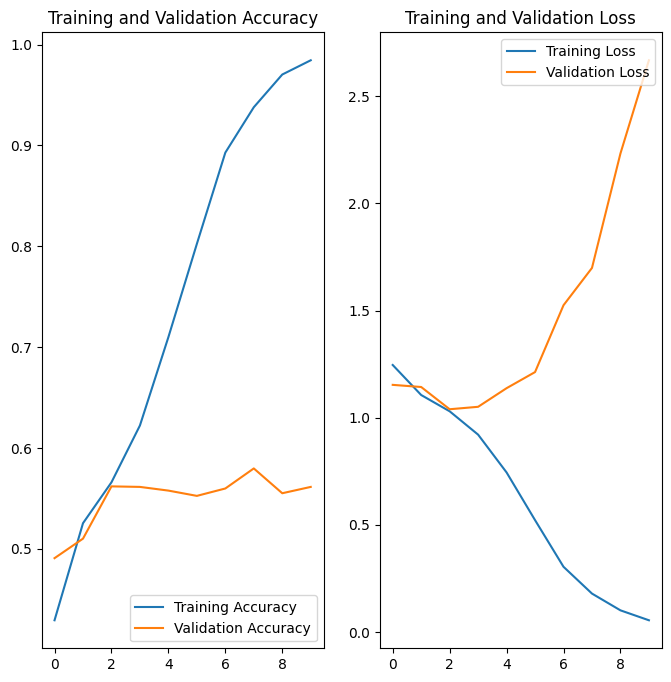

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Fixing Overfitting with Data Augmentation

In [16]:
# the drastic difference in accuracy between training and validation accuracy is noticeable. This is Overfitting
# Overfitting: When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples
# Solution: takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images
# This helps expose the model to more aspects of the data and generalize better.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

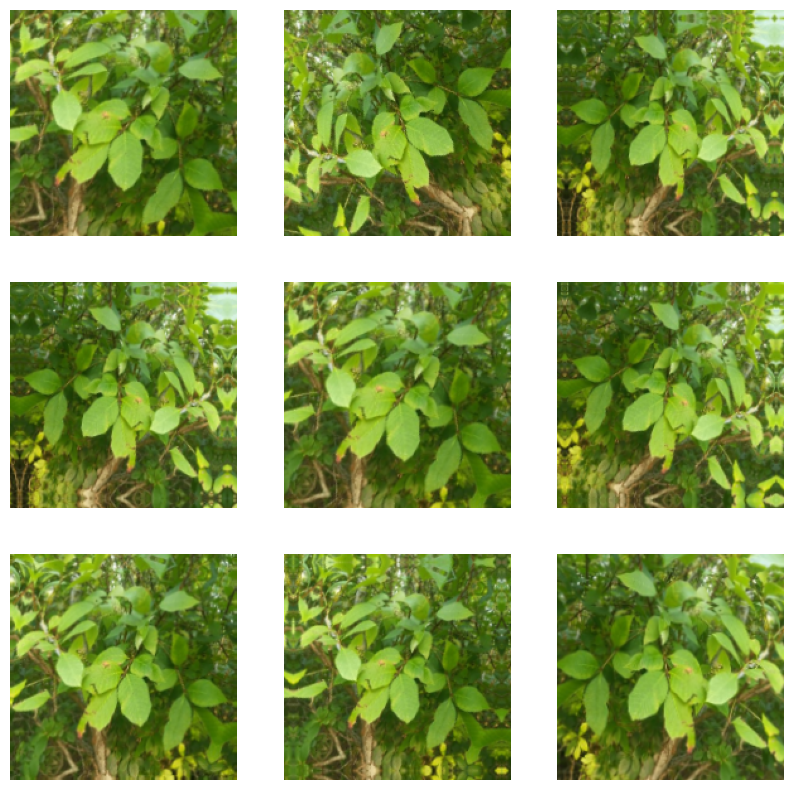

In [17]:
# plotting a new figure
plt.figure(figsize = (10, 10))

# Visualize a few augmented examples by applying data augmentation to the same image several times
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Fixing Overfiting with Dropout

In [18]:
# When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [19]:
# recompile the model
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [21]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
239/239 [==============================] - 401s 2s/step - loss: 1.3606 - accuracy: 0.3290 - val_loss: 1.2673 - val_accuracy: 0.4014
Epoch 2/15
239/239 [==============================] - 239s 1000ms/step - loss: 1.2285 - accuracy: 0.4333 - val_loss: 1.1804 - val_accuracy: 0.4631
Epoch 3/15
239/239 [==============================] - 193s 807ms/step - loss: 1.1650 - accuracy: 0.4822 - val_loss: 1.1271 - val_accuracy: 0.5243
Epoch 4/15
239/239 [==============================] - 183s 766ms/step - loss: 1.1333 - accuracy: 0.5001 - val_loss: 1.1676 - val_accuracy: 0.5102
Epoch 5/15
239/239 [==============================] - 202s 845ms/step - loss: 1.0848 - accuracy: 0.5346 - val_loss: 1.1997 - val_accuracy: 0.5050
Epoch 6/15
239/239 [==============================] - 191s 801ms/step - loss: 1.0532 - accuracy: 0.5536 - val_loss: 1.2058 - val_accuracy: 0.5071
Epoch 7/15
239/239 [==============================] - 188s 785ms/step - loss: 1.0222 - accuracy: 0.5679 - val_loss: 1.0185 - v

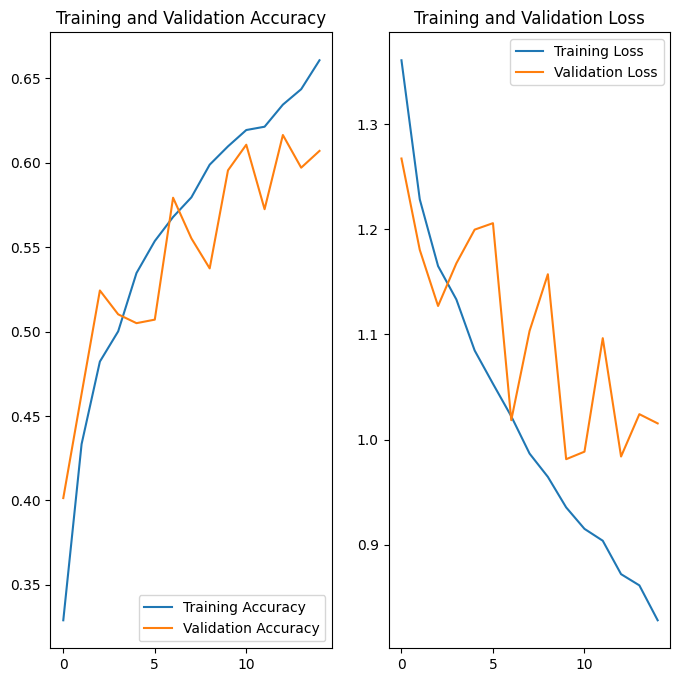

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Add weight regularization

In [33]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [34]:
# recompile the model
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [37]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1899, in _run_once
      handle._run()
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\chibi\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\chibi\AppData\Local\Temp\ipykernel_15548\3973865498.py", line 2, in <module>
      history = model.fit(
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\chibi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 3 which is outside the valid range of [0, 1).  Label values: 0 3 1 3 2 2 1 3 2 0 3 2 1 2 0 0 1 3 3 3 1 2 3 1 1 0 3 2 2 3 3 1
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_61065]

13. Testing model on new Data

In [23]:
# test for box elder (similar to poison ivy, but classifies as not poisonous)
box_elder_path = 'C:/Users/chibi/OneDrive/GitHub/SDP_2022-2023/box_elder_test.jpg'

img = tf.keras.utils.load_img(
    box_elder_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This box elder most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 13s 13s/step
This box elder most likely belongs to Not with a 37.44 percent confidence.


In [24]:
# test for coleus (not poisonous)
coleus_path = 'C:/Users/chibi/OneDrive/GitHub/SDP_2022-2023/coleus_test.jpg'

img = tf.keras.utils.load_img(
    coleus_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This coleus most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 126ms/step
This coleus most likely belongs to Not with a 99.97 percent confidence.


In [25]:
# test for sunflower (classifies as not poisonous)
sunflower_path = 'C:/Users/chibi/OneDrive/GitHub/SDP_2022-2023/sunflower_test.jpg'

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This sunflower most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 322ms/step
This sunflower most likely belongs to Not with a 63.15 percent confidence.


In [26]:
# test for poison oak 
poison_oak_path = 'C:/Users/chibi/OneDrive/GitHub/SDP_2022-2023/poison_oak_test.jpg'

img = tf.keras.utils.load_img(
    poison_oak_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This poison oak most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 130ms/step
This poison oak most likely belongs to Atlantic_Poison_Oak with a 95.60 percent confidence.


In [27]:
# test for poison ivy 
poison_ivy_path = 'C:/Users/chibi/OneDrive/GitHub/SDP_2022-2023/poison_ivy_test.jpg'

img = tf.keras.utils.load_img(
    poison_ivy_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This poison ivy most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 204ms/step
This poison ivy most likely belongs to Atlantic_Poison_Oak with a 68.34 percent confidence.


In [28]:
# test for poison sumac
poison_sumac_path = 'C:/Users/chibi/OneDrive/GitHub/SDP_2022-2023/poison_sumac_test.jpg'

img = tf.keras.utils.load_img(
    poison_sumac_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This poison sumac most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 231ms/step
This poison sumac most likely belongs to Poison_Sumac with a 93.23 percent confidence.
